# Spectral Clustering

```{figure} /images/clustering/facebook.jpg
---
height: 300px
name: Social Graph 
align: center
---
Graph clustering is relevant for example in social relation analysis
```
Interpretation of data as a graph. Every data point is a node. The weight of an edge reflects the similarity between connected nodes.     
Epsilon neighborhood similarity:
$$W_{ij}= \begin{cases}1& \text{if } \lVert D_{i\cdot}-D_{j\cdot}\rVert<\epsilon\\
0& \text{otherwise}\end{cases}$$

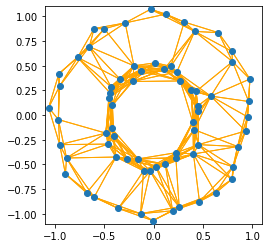

In [1]:
from scipy import sparse
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
epsilon=0.05
D, labels = datasets.make_circles(n_samples=70, factor=.5, noise=epsilon)
from sklearn.neighbors import radius_neighbors_graph
sA = radius_neighbors_graph(D, 0.5, mode='connectivity',include_self=False)
#A=np.exp(-8*(np.sum(D**2,1).reshape(-1,1)  - 2* D@D.T + np.sum(D.T**2,0)))
#A = A/ np.max(A)
#A *= np.tri(*A.shape)
#A*= (A>0.08)
#A=A[A>0.08]
#sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")

k-nearest neighbor similarity:
$$N_{ij}= \begin{cases}1& \text{if } D_{i\cdot} \in KNN(D_{j\cdot})\\
0& \text{otherwise}\end{cases},\quad W=\frac12(N+N^\top)$$

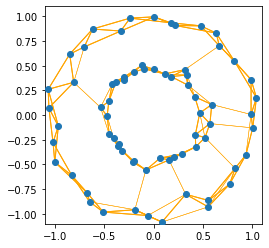

In [2]:
from scipy import sparse
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
epsilon=0.05
D, labels = datasets.make_circles(n_samples=70, factor=.5, noise=epsilon)
from sklearn.neighbors import kneighbors_graph

sA = kneighbors_graph(D, 4, mode='connectivity', include_self=False)
sA = 0.5*(sA+sA.T)
#A=np.exp(-8*(np.sum(D**2,1).reshape(-1,1)  - 2* D@D.T + np.sum(D.T**2,0)))
#A = A/ np.max(A)
#A *= np.tri(*A.shape)
#A*= (A>0.08)
#A=A[A>0.08]
#sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")

## Formal Problem Definition
The similarity between points is given by a weighted adjacency matrix.
\begin{align*}
W = \begin{pmatrix}
0 & 6 & 0 & 0 & 5 & 0\\
6 & 0 & 1 & 0 & 7 & 0\\
0 & 1 & 0 & 9 & 8 & 2\\
0 & 0 & 9 & 0 & 4 & 3\\
5 & 7 & 8 & 4 & 0 & 0\\
0 & 0 & 2 & 3 & 0 & 0
\end{pmatrix}
\end{align*}

```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};

   \foreach \i/\j/\t in {1/2/1, 2/3/2, 3/4/3, 4/5/4, 5/6/5, 6/1/6, 5/1/7, 5/2/8, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
We compute the similarity within a cluster.
\begin{align*}
Y_{\cdot s}^\top&=\begin{pmatrix}
1& 1& 0& 0&1 &0
\end{pmatrix}\\
Y_{\cdot s}^\top WY_{\cdot s}
&= 2(5+6+7)
\end{align*}

\begin{align*}
Sim(Y;W)&=\tr(Y^\top W Y(Y^\top Y)^{-1})\\
&=\sum_{s=1}^r\frac{Y_{\cdot s}^\top W Y_{\cdot s}}{\lvert Y_{\cdot s}\rvert}
=\sum_{s=1}^r\frac{1}{\lvert \mathcal{C}_{s}\rvert}\sum_{i,j\in\mathcal{C}_s} W_{ji}
\end{align*}
```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
    {\ifnum \x>0
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \else
     \node [circle,draw=magenta,fill=magenta!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \fi};

   \foreach \i/\j/\t in {5/6/5, 6/1/6, 5/1/7}
    \draw [draw=magenta, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
   
   \foreach \i/\j/\t in {4/5/4, 1/2/1, 2/3/2, 3/4/3, 5/2/8, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
We compute the cut of a cluster.
\begin{align*}
Y_{\cdot s}^\top&=\begin{pmatrix}
1& 1& 0& 0&1 &0
\end{pmatrix}\\
Y_{\cdot s}^\top W (\vvec{1}-Y_{\cdot s})
&= 1+8+4
\end{align*}
\begin{align*}
Cut(Y;W)&=\tr((\vvec{1}-Y)^\top W Y(Y^\top Y)^{-1}) \\
&= \sum_{s=1}^r\frac{(\vvec{1}-Y_{\cdot s})^\top WY_{\cdot s}}{\lvert Y_{\cdot s}\rvert} 
= \sum_{s=1}^r\frac{1}{\lvert \mathcal{C}_s\rvert}\sum_{i\notin\mathcal{C}_s}\sum_{j\in\mathcal{C}_s}W_{ij}
\end{align*}
```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
    {\ifnum \x>0
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \else
     \node [circle,draw=magenta,fill=magenta!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \fi};

   \foreach \i/\j/\t in {1/2/1, 5/2/8, 4/5/4}
    \draw [draw=magenta, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
   
   \foreach \i/\j/\t in {5/6/5, 6/1/6, 5/1/7, 2/3/2, 3/4/3, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```

There are principally two ways to define clusters of graphs:
* maximize the sum of weights within clusters
* minimize the sum of weights between clusters

`````{admonition} Task (Maximum Similarity Graph Clustering)
:class: tip
**Given** a graph indicated by a symmetric, nonnegative similarity matrix $W\in\mathbb{R}_+^{n\times n}$, and the number of clusters $r$.     
**Find** clusters indicated by the matrix $Y\in\mathbb{1}^{n\times r}$ which maximize the similarity of points within a cluster
\begin{align*}
 \max_Y Sim(Y;W)&=\tr(Y^\top W Y(Y^\top Y)^{-1}) &\text{s.t. } Y\in\mathbb{1}^{n\times r}
\end{align*}
**Return** the clustering $Y\in\mathbb{1}^{n\times r}$
`````
`````{admonition} Task (Minimum Cut Graph Clustering)
:class: tip
**Given** a graph indicated by a symmetric, nonnegative similarity matrix $W\in\mathbb{R}_+^{n\times n}$, and the number of clusters $r$.     
**Find** clusters indicated by the matrix $Y\in\mathbb{1}^{n\times r}$ which minimize the cut of all clusters
\begin{align*}
 \min_YCut(Y;W)&=\tr((\vvec{1}-Y)^\top W Y(Y^\top Y)^{-1}) &\text{s.t. } Y\in\mathbb{1}^{n\times r}
\end{align*}
**Return** the clustering $Y\in\mathbb{1}^{n\times r}$
`````



## Optimization
````{prf:definition} Degree Matrix and Graph Laplacian
Given a graph indicated by a weighted adjacency matrix $W\in\mathbb{R}_+^{n\times n}$.      
The **degree matrix** is the diagonal matrix having the sum of all connecting edges for each node on the diagonal: $$I_W = \mathrm{diag}\left(\sum_{i=1}^n W_{1i},\ldots,\sum_{i=1}^n W_{ni}\right).$$     
The **graph Laplacian** is the matrix $$L=W-I_W$$.
````

````{prf:example}
```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};

   \foreach \i/\j/\t in {1/2/1, 2/3/2, 3/4/3, 4/5/4, 5/6/5, 6/1/6, 5/1/7, 5/2/8, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
$$I_W = 
\begin{pmatrix}
    11 & 0 & 0 & 0 & 0 & 0\\
    0 & 14 & 0 & 0 & 0 & 0\\
    0 & 0 & 20 & 0 & 0 & 0\\
    0 & 0 & 0 & 16 & 0 & 0\\
    0 & 0 & 0 & 0 & 24 & 0\\
    0 & 0 & 0 & 0 & 0 & 5
\end{pmatrix}$$

````
We have $Y_{\cdot s}^\top WY_{\cdot s}\leq Y_{\cdot s}I_WY_{\cdot s} $ where $I_W$ is the degree matrix.
    
$Y_{\cdot s}^\top WY_{\cdot s}=Y_{\cdot s}^\top I_WY_{\cdot s}$ if and only if $Y_{\cdot s}$ indicates a connected component. This is equivalent to 
$$Y_{\cdot s}^\top \underbrace{(I_W - W)}_{=L}Y_{\cdot s }=0$$
```{prf:theorem} Minimum Cut and Maximum Similarity Equivalences 
Given a symmetric similarity matrix $W\in\mathbb{R}^{n\times n}_+$, the degree matrix $I_W$ and the Graph Laplacian $L=I_W-W$, then the following objectives are equivalent:
\begin{align*}
    \min_YCut(Y;W)  &= \tr((\vvec{1}-Y)^\top WY(Y^\top Y)^{-1}) &\text{s.t }Y\in\mathbb{1}^{n\times r} \\
    \max_Y Sim(Y;-L) &= \tr(Y^\top (-L) Y(Y^\top Y)^{-1}) &\text{s.t }Y\in\mathbb{1}^{n\times r}
\end{align*}
```
The maximum similarity objective is equal to the kernel $k$-means objective. However, note that $-L$ is not a kernel matrix (it's negative semi-definite). 

```{prf:lemma} Positive Definiteness of Laplacians
Given a symmetric similarity matrix $W\in\mathbb{R}^{n\times n}_+$, the Laplacian $L=I_W -W$ is positive semi-definite.
```
````{toggle}
```{prf:proof}
Let $0\neq v\in\mathbb{R}^n$, then
\begin{align*}
v^\top Lv &= v^\top I_W v - v^\top W v 
= \sum_{i=1}^n v_i^2 \lvert W_{i\cdot}\rvert -\sum_{1\leq i,j\leq n} v_iv_jW_{ij}\\
&= \frac{1}{2} \sum_{1\leq i,j \leq n} (v_i^2 W_{ij} -2 v_iv_jW_{ij} +v_j^2W_{ij}) \\
&= \frac{1}{2} \sum_{1\leq i,j \leq n} W_{ij} (v_i-v_j)^2 \geq 0.
\end{align*}
```
````

```{prf:theorem} Connected Components and Eigenvectors
Given a graph indicated by the symmetric matrix $W\in\mathbb{R}^{n\times n}_+$, then the indicator vectors of the connected components are eigenvectors of the Laplacian $L=I_W-W$ to the smallest eigenvalue $0$.   
```
````{toggle}
```{prf:proof}
For every connected component there exists an order of columns and rows such that $W$ has a block-diagonal form:
\begin{align} 
Wv = 
\left(
\begin{array}{c:r}
\begin{matrix}
 W_{11}&\ldots&W_{1c}  \\
 \vdots&&\vdots \\
 W_{c1}&\ldots&W_{cc} \\
\end{matrix}
& \mathbf{0}\\
\mathbf{0} & \widehat{W} \\
\end{array}
\right)
\begin{pmatrix}
 1\\
 \vdots\\
 1 \\
 \mathbf{0} 
\end{pmatrix}
=
\begin{pmatrix}
 \lvert W_{1\cdot}\rvert\\
 \vdots\\
 \lvert W_{c\cdot}\rvert \\
 \mathbf{0} 
\end{pmatrix}
=I_Wv.
\end{align}
```
````
The standard method to solve the minimum cut objective is called Spectral Clustering. The idea of Spectral Clustering is the same as of kernel $k$-means with few alterations. Instead of using the full eigendecomposition, Spectral Clustering uses only the first $r$ meaningful eigenvectors which are not indicating the connected component.
```{prf:algorithm} spectral clustering
**Input**: data matrix $D$, number of clusters $r$, similarity matrix $W$      
**Require**: the similarity matrix should indicate a connected graph
1. $L\gets I_W-W$ *(Compute Graph Laplacian - other graph Laplacians are also possible)*
2. $(V,\Lambda) \gets$ `TruncatedEigendecomposition`$(L,r+1)$
3. $A\leftarrow V_{\cdot\{2,\ldots, r+1\}}$ *(Remove connected component)*
4. $(X,Y)\gets$`kMeans`$(A,r)$
3. **return** $Y$
```

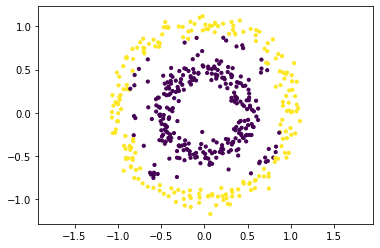

In [3]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

D, labels = datasets.make_circles(n_samples=500, factor=.5, noise=0.08)
W= rbf_kernel(D, D,gamma=0.3)
L= np.diag(np.sum(W,1))-W
lambdas, V = np.linalg.eig(L)
kmeans = KMeans(n_clusters=2,n_init=1)
A = np.abs(V[:,1:3])
kmeans.fit(A)
plt.scatter(D[:, 0], D[:, 1], c=kmeans.labels_, s=10)
plt.axis('equal')
plt.show()

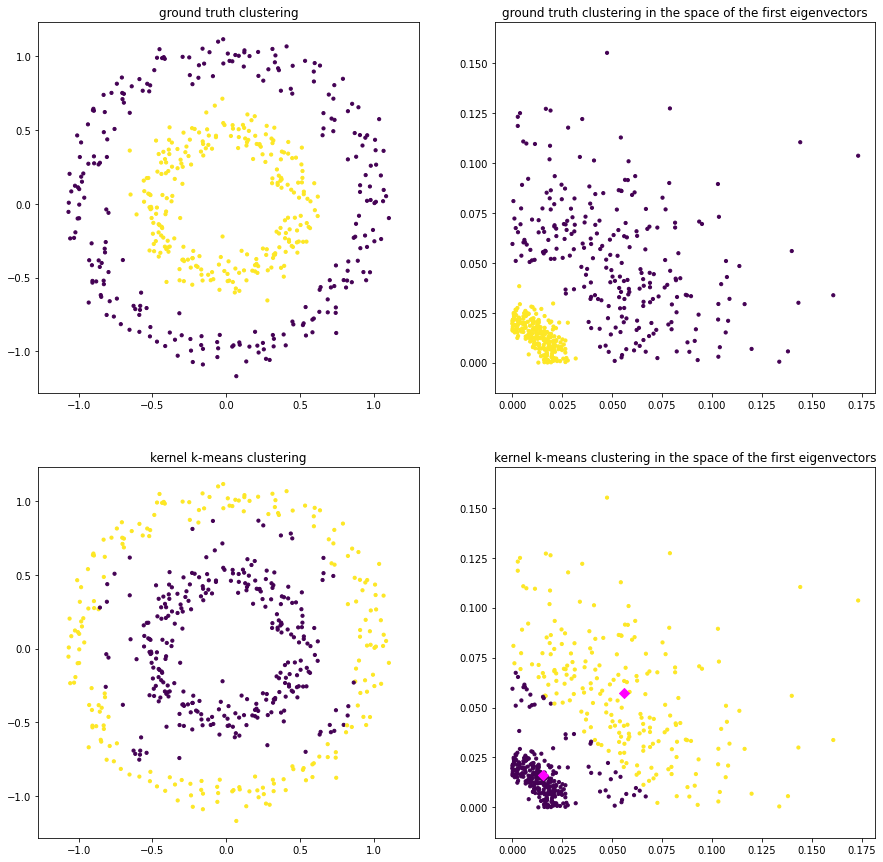

In [4]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.scatter(D[:, 0], D[:, 1], s=10, c=labels) 
plt.title("ground truth clustering")
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(A[:, 0], A[:, 1], s=10, c=labels) 
plt.title("ground truth clustering in the space of the first eigenvectors")
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.scatter(D[:, 0], D[:, 1], s=10, c=kmeans.labels_) 
plt.title("kernel k-means clustering")
plt.axis('equal')

plt.subplot(2, 2, 4)
plt.scatter(A[:, 0], A[:, 1], s=10, c=kmeans.labels_) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='magenta', s=50, marker = 'D')
plt.title("kernel k-means clustering in the space of the first eigenvectors")
plt.axis('equal')
plt.show()

In practice, the weighted adjacency matrix is often normalized. The corresponding Graph Laplacian is often denoted by
$$ L_{sym}= I-I_W^{-1/2}WI_W^{-1/2}$$